# Introduction
"Sentiment analysis refers to the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information." ([wiki](https://en.wikipedia.org/wiki/Sentiment_analysis)) <br>
Sentiment analysis allows us to detect the attitude of an opinion, a review...   <br>
Take product reviews for example, by analyzing the reviews, we can know what attitudes to consumers hold toward a product; take tweets as an example, we may be able to discover the political attitude of a person by analyzing his/her tweets. <br>

This can be widely applied, while in this tutorial we will take classifying positive/negative product reviews for example.

# Tutorial content

In this tutorial, I will show some ways to do sentiment analysis in Python, specifically using [NLTK](http://www.nltk.org/), [spaCy](https://spacy.io/) and [scikit-learn](http://scikit-learn.org/stable/).

We'll be using product reviews data in the [nltk corpus](http://www.nltk.org/nltk_data/): 
> _53. Product Reviews(9 Products)_<br>
   id: `product_reviews_2`

There are reviews of 9 products in this dataset.  The data is from Amazon.com.  Though the data is a bit out of date(2007), we can still use it to do sentiment analysis.

Each review is classified as positive or negative.  We will use them to train a model that is able to classify whether a review is positive or negative.


We will cover the following topics in this tutorial:
- [Installing the libraries](#Installing-the-libraries)
- [Loading and preprocessing data](#Loading-and-preprocessing-data)

- [Lemmatizing words](#Lemmatizing-words)
  1. [Using spaCy](#Using-spaCy)
  2. [Using NLTK WordNetLemmatizer](#Using-NLTK-WordNetLemmatizer)

- [Training classifiers](#Training-classifiers)
  1. [Using NLTK NaiveBayesClassifier](#Using-NLTK-NaiveBayesClassifier)
  2. [Using sklearn BernoulliNB](#Using-sklearn-BernoulliNB)

## Installing the libraries

__1. Install spaCy__

Open the terminal in jupyter notebook, type the following commands:<br>

`conda config --add channels
conda-forge conda install spacy
python -m spacy download en`



__2. Install NLTK__

If using anaconda, nltk should be installed with anaconda.<br>
Simply run `import nltk` in the terminal.<br>
In case that didn't work, run the following command to install NLTK:<br>
`
conda install -c anaconda nltk 
`

## Loading and preprocessing data

Press [here](https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/product_reviews_2.zip) to download the data__ _Product Reviews(9 Products)_ __

In [1]:
import nltk
nltk.download('product_reviews_2')
# http://www.nltk.org/_modules/nltk/corpus/reader/reviews.html

[nltk_data] Downloading package product_reviews_2 to
[nltk_data]     /Users/Amyhuang/nltk_data...
[nltk_data]   Package product_reviews_2 is already up-to-date!


True

In [2]:
from nltk.corpus import product_reviews_2
read_me = product_reviews_2.readme()
for i in read_me.splitlines():
    print(i)

Product Reviews (9 products)

Available as ‘Additional Review Datasets (9 products)’ from
http://www.cs.uic.edu/~liub/FBS/FBS.html

Source:
http://www.cs.uic.edu/~liub/FBS/Reviews-9-products.rar

NB: Line-endings have been converted from DOS to Unix, and some
control characters and extended ASCII characters have been converted
to UTF-8.


*****************************************************************************
* Contact: Bing Liu, liub@cs.uic.edu 
*          http://www.cs.uic.edu/~liub
*****************************************************************************

                            README file

This folder contains annotated customer reviews of 9 products. 


All the reviews were from amazon.com. The data was used in the following 
paper:

Xiaowen Ding, Bing Liu and Philip S. Yu. 
	“A Holistic Lexicon-Based Approach to Opinion Mining." 
	Proceedings of First ACM International Conference on Web Search and Data Mining 
	(WSDM-2008), Feb 11-12, 2008, Stanford University, Sta

By looking at the README file, we get to understand the dataset.<br>
We will only be looking at '+' and '-' in [+n]/[-n] since the README file mentioned 'the strength is quite subjective'.<br>
Therefore, the information we will extract include '+', '-' and the content of reviews.

The following are 9 files with the reviews of each product.

In [3]:
product_reviews_2_fileids = product_reviews_2.fileids()
product_reviews_2_fileids

['Canon_PowerShot_SD500.txt',
 'Canon_S100.txt',
 'Diaper_Champ.txt',
 'Hitachi_router.txt',
 'Linksys_Router.txt',
 'MicroMP3.txt',
 'Nokia_6600.txt',
 'README.txt',
 'ipod.txt',
 'norton.txt']

Let's take a look at the raw data.

In [4]:
data = product_reviews_2.raw(product_reviews_2_fileids[0]).splitlines()
for r in data[:5]:
    print(r + '\n')

[t]

SD500[+2]##We really enjoyed shooting with the Canon PowerShot SD500. 

design[+2]##It has an exterior design that combines form and function more elegantly than any point-and-shoot we've ever tested. 

image-processing system[+1]##A Digic II-powered image-processing system enables the SD500 to snap a limitless stream of 7-megapixel photos at a respectable clip, its start-up time is tops in its class, and it delivers decent photos when compared to its competition. 

image[+2]##The SD500 rivals the Canon G6 in image quality. 



Extract the label('+' or '-') and the content of the review. 
Save these info in `reviews`.

In [5]:
import re
reviews = []
pre_label = []
pre_content = []
for field in product_reviews_2_fileids:
    data = product_reviews_2.raw(field).splitlines()
    for r in data:
        label_finder = re.compile(r'\[([+-])[123]\]')
        content_finder = re.compile('##(.+)')
        label = label_finder.findall(r)
        content = content_finder.findall(r)
        
        if len(pre_label) >= 1 and len(pre_content) == 0 and len(label) == 0 and len(content) == 1:
            label = pre_label
        if len(label) >= 1 and len(content) == 1:
            reviews.append([label, content[0]])
        if len(label) == 0 and len(content) == 1:
            if len(reviews) > 0:
                reviews[-1][1] += (content[0])
        pre_label = label
        pre_content = content
# print(len(reviews))

In [6]:
print(reviews[0])

[['+'], 'We really enjoyed shooting with the Canon PowerShot SD500. ']


Reviews can be tagged with more than one feature(which means more than one label)<br>
Some may have both '+' and '-' labels.  It will be hard to classify whether the review is positive or negative.<br> Therefore, we only preserve reviews that have only one of the labels.<br>
This way, it will be much clearer whether the review is positive or negative.

In [7]:
for review in reviews:
    if len(review[0]) > 1:
        if (all(l== '+' for l in label) or all(l== '-' for l in label)):
            review[0] = [review[0][-1]]
        else:
            del reviews[reviews.index(review)]

Save label of reviews separately.
'+' is saved as 1 in `label`; '-' is saved as 0.
The following is an overview of the number of reviews we have; how many are positive; how many are negative.

In [8]:
num_pos = 0
num_neg = 0
label = []
for review in reviews:
    if review[0][0] == '+':
        num_pos += 1
        label.append(1)
    else:
        num_neg += 1
        label.append(0)
print('# of positive reviews:', num_pos)
print('# of negative reviews:', num_neg)
print('                Total:', num_pos + num_neg)

# of positive reviews: 1336
# of negative reviews: 751
                Total: 2087


## Lemmatizing words

The base form of a word, that one might look up in a dictionary, is called the __lemma__ or __dictionary form__ for the word.([wikipedia](https://en.wikipedia.org/wiki/Lemmatisation))<br>
For example, 'walked', 'walks' and 'walking' all have the same base form 'walk'(verb).  In other words, the verb 'walk' is the lemma of 'walked', 'walks' and 'walking'. <br>

By lemmatizing the words, which means we will be able to analyze the reviews better.<br>
Otherwise, words like 'shooting' and 'shoot' will be treated as different words though they are basically the same.<br>

In the following, we will go through two ways to lemmatize words.
1. spaCy
2. NLTK

### Using spaCy

The method `make_lemmatized_word_list` will do the following using spaCy:<br>
* First, we can tokenize words in a sentence by calling `nlp(sentence)`.<br>
* Next, we can access the `lemma_` (Base form of the [token](https://spacy.io/api/token)) of each token.<br>

In [9]:
from nltk.corpus import stopwords
import spacy
nlp = spacy.load('en')

In [10]:
def make_lemmatized_word_list(text):
    #tokenize the cotent of reviews
    #i.e. each review will be a spacy.tokens.doc.Doc, each word will be a spacy.tokens.token.Token
    tokenized_text = nlp(text.lower())
    lemmatized = []
    for token in tokenized_text:
        lemma = token.lemma_
        if re.match('[a-zA-Z]+$', lemma) and (lemma not in stopwords.words("english")) and (not (token.is_stop)):
            lemmatized.append(lemma)
    return lemmatized

In [11]:
lemma_spacy = [make_lemmatized_word_list(i[1]) for i in reviews]

Let's take a look at the lemmatized word list of reviews(using spaCy):

In [12]:
lemma_spacy[:2]

[['enjoy', 'shoot', 'canon', 'powershot'],
 ['exterior',
  'design',
  'combine',
  'form',
  'function',
  'elegantly',
  'point',
  'shoot',
  'test']]

### Using NLTK WordNetLemmatizer

nltk also has WordNetLemmatizer which can lemmatize words. <br>
We should provide `pos` while using `WordNetLemmatizer.lemmatize()` to get a more accurate outcome (the default is `pos = NOUN`)<br>
(From the [documentation](http://www.nltk.org/_modules/nltk/corpus/reader/wordnet.html), we can see that `POS_LIST = [NOUN, VERB, ADJ, ADV]`)

By using `pos_tag(word_tokenize(word))`(see this [link](http://www.nltk.org/_modules/nltk/tag.html) for ducumentation), we can get the [Penn Treebank tag](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html) of the word.<br>

The following method `get_wordnet_pos` can map Penn Treebank tag to `pos`.<br>

In [13]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/Amyhuang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag, word_tokenize
#map Penn Treebank tag to wornet pos
def get_wordnet_pos(tag):
    if tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
#transform a sentence into a list of lemmatized words
def make_word_list(sent):
    lemmatizer = WordNetLemmatizer()
    lemmatized_word_list = []
    for word, tag in pos_tag(word_tokenize(sent.lower())):
        wntag = get_wordnet_pos(tag)
        if not wntag:
            lemma = word
        else:
            lemma = lemmatizer.lemmatize(word, wntag)

        if re.match('[a-zA-Z]+$', lemma) and (lemma not in stopwords.words("english")):
            lemmatized_word_list.append(lemma)
    return lemmatized_word_list

In [15]:
lemma_nltk = [make_word_list(i[1]) for i in reviews]

Let's take a look at the lemmatized word list of reviews(using NLTK):

In [16]:
lemma_nltk[:2]

[['really', 'enjoy', 'shoot', 'canon', 'powershot'],
 ['exterior',
  'design',
  'combine',
  'form',
  'function',
  'elegantly',
  'ever',
  'test']]

The lemmatizing outcome using spaCy and using NLTK is different.  This is pretty clear by looking at the first review.
One has the word 'really' and the other doesn't.<br>

## Training classifiers

Before training the model, we use train_test_split in sklearn to generate train set and test set. <br>
Note: we will use `lemma_nltk`, the lemmatized outcome using nltk, in the following part.

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(lemma_nltk, label, test_size=0.25, random_state=15688)

In [18]:
print('Number of reviews in train set and test set')
print('X_train:', len(X_train))
print('y_train:', len(y_train))
print('X_test :', len(X_test))
print('y_test :', len(y_test))

Number of reviews in train set and test set
X_train: 1565
y_train: 1565
X_test : 522
y_test : 522


We have 1565 samples as the train set and 522 samples as the test set.
Next, we will go through two ways of training a classifier:
1. NLTK NaiveBayesClassifier
2. sklearn BernoulliNB

### Using NLTK NaiveBayesClassifier

First, let's use [NaiveBayesClassifier](http://www.nltk.org/_modules/nltk/classify/naivebayes.html) in nltk.<br>
There is a specific format for the input of NaiveBayesClassifier.<br>
The documentation of nltk says, 'The first step in creating a classifier is deciding what features of the input are relevant, and how to encode those features.' <br>
Next, 'we need to prepare a list of examples and corresponding class labels.' Which means transferring each data into the following format: <br>
(encoded features, class label) <br>
Please look at the examples given in this [document](http://www.nltk.org/book/ch06.html) for further details.

In our case, the feature we are using will be whether a word(lemma) exists in the review.
Each review will be transformed to a tuple with the following format: <br>
( a dictionary of lemma, positive/negative ) <br>

Let's take a review as example:<br>

> The original review:<br>
> `We really enjoyed shooting with the Canon PowerShot SD500. `<br>
> The lemmatized word list of this sentence:<br>
> `['enjoy', 'shoot', 'canon', 'powershot']`<br>
> The input of NaiveBayesClassifier:<br>
> `({'enjoy': True, 'shoot': True, 'canon': True, 'powershot': True}, 'positive')`<br>

The following is transforming the reviews to the specific format for training the NaiveBayesClassifier.

In [19]:
def make_word_dic(X):
    dictionary = {}
    for word in X:        
        dictionary[word] = True
    return dictionary
def make_nb_input(X, y):
    annote_reviews = []
    for words, sign in zip(X, y):
        if sign == 1:
            annote_reviews.append((make_word_dic(words), 'positive'))
        else:
            annote_reviews.append((make_word_dic(words), 'negative'))
    return annote_reviews

annote_X_train = make_nb_input(X_train, y_train)
annote_X_test = make_nb_input(X_test, y_test)

We train the classifier by calling `NaiveBayesClassifier.train(annoted_X_train)`, and get the accuracy by calling `util.accuracy(classifier, annote_X_test)`.

In [20]:
from nltk.classify import NaiveBayesClassifier
from nltk.classify import util

classifier = NaiveBayesClassifier.train(annote_X_train)
accuracy = util.accuracy(classifier, annote_X_test)
print('Accuracy:' , accuracy)

Accuracy: 0.6475095785440613


By calling `show_most_informative_features()`, we can see what lemmas are most informative while classifying whether the review is positive or negative.

In [21]:
classifier.show_most_informative_features(n = 20)

Most Informative Features
                 scratch = True           negati : positi =     12.3 : 1.0
                    pain = True           negati : positi =     12.3 : 1.0
                customer = True           negati : positi =     11.6 : 1.0
                    flaw = True           negati : positi =     10.0 : 1.0
                     fix = True           negati : positi =      9.5 : 1.0
                    site = True           negati : positi =      8.3 : 1.0
              completely = True           negati : positi =      8.1 : 1.0
               sometimes = True           negati : positi =      8.1 : 1.0
                   audio = True           positi : negati =      7.8 : 1.0
                    pull = True           negati : positi =      7.6 : 1.0
                  damage = True           negati : positi =      7.6 : 1.0
                   later = True           negati : positi =      6.7 : 1.0
                    stay = True           negati : positi =      6.4 : 1.0

If 'pain' appears in the review, the chance that it is a negative review is 12.3 times more than the chance that it is a positive review. <br>
It is reasonable when words like 'pain', 'scratch', 'damage', 'annoy'... appear in the review, it's more likely that it is a negative review. <br>

The classifier can also test other reviews by using `classifier.classify(review)`<br>
The input should be encoded features, a dictionary of lemma in our case.

In [22]:
# this is a 1-star review I got on Amazon (https://www.amazon.com/VicTsing-Wireless-Portable-Receiver-Adjustable/product-reviews/B013WC0P2A/ref=cm_cr_dp_d_hist_1?ie=UTF8&filterByStar=one_star&reviewerType=all_reviews#reviews-filter-bar)
testing_rev = '''The mouse pauses every couple seconds. Tested this on a few computers and it does the same thing. Not sure if this is a common problem but i wanted it to be known that this does happen.

The scroll wheel on mine seems to be misshaped and gets caught on something when scrolling.

Overall, the build quality of the mouse is sub par. I have bought sub-$20 mice in the past and this is honestly one of the worst ones i've used. Will be requesting a return and refund.'''

In [23]:
classifier.classify(make_word_dic(make_word_list(testing_rev)))

'negative'

This 1-star review is classified as a negative review.  Though this doesn't mean everything, at least for this example the classifier seems to be working ok.

### Using sklearn BernoulliNB

Next, let's use sklearn to train a classifier. <br>
First, we transform reviews into the proper format. <br>
We use [CountVecotizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) to make a sparse matrix with size `nxw`. <br>
`n` is the number of reviews; `w` is the number of words. <br>
The `(i, j)` value will be the number of times `jth` word appeared in `ith` review. <br>


Note: The input should be a sentence not a list of words; therefore, we transform the list of words back to a string.

In [24]:
context_text = [" ".join(i) for i in X_train]

We can set max_df and min_df to give a threshold of the frequency(float) or absolute counts(integer) vocabulary appear in the documents.
Also, we can specify stop_words = 'english' to exclude stopwords from the vocabulary.

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

count_vector = CountVectorizer(min_df = 5, stop_words = "english", max_df = 0.9)

X = count_vector.fit_transform(context_text)

print('Size of vocabulary(lemma):', X.shape[1])

Size of vocabulary(lemma): 800


Part of vocabulary lists:

In [26]:
print(count_vector.get_feature_names()[:10])
print(count_vector.get_feature_names()[-10:])

['ability', 'able', 'absolutely', 'access', 'accessory', 'actual', 'actually', 'adapter', 'add', 'addition']
['wrench', 'write', 'wrong', 'xp', 'yahoo', 'yeah', 'year', 'yes', 'zen', 'zoom']


Next, we use [BernoulliNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB.score) as the classifier. <br>
BernoulliNB has some parameters that we can decide its value. <br>
By using cross-validation, the best hyperparameter for the test set can be chosen.  In our case, alpha, additive (Laplace/Lidstone) smoothing parameter, is the hyperparameter we can choose. <br>

The following is splitting train set into 5 folds and assign one file as the validation set each time and iterate 5 times.<br>
The validation set is used to evaluate the performance. <br>
The alpha that has the best performance(in this case we use f1_score) on average is the best alpha.<br>

In [27]:
import numpy as np
label_np = np.asarray(y_train)

In [28]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB

num_folds = 5
k_fold = KFold(num_folds, shuffle = True, random_state = 15688)
max_score = 0
best_alpha = 0
for a in range(1,51):
    alpha_test = a/10
    nb = BernoulliNB(alpha = alpha_test)
    
    total_score = 0
    for train, test in k_fold.split(X, label_np):
        nb.fit(X[train], label_np[train])
        label_predict = nb.predict(X[test])
        score = f1_score(label_np[test], label_predict)
        total_score += score
    mean_score = total_score/num_folds
    if mean_score > max_score:
        max_score = mean_score
        best_alpha = alpha_test
print("best_alpha:", best_alpha)

best_alpha: 2.1


After getting the best alpha, train the model using best alpha as the parameter.

In [29]:
nb = BernoulliNB(alpha = best_alpha)
nb.fit(X, np.asarray(y_train))
X_test_join = [" ".join(i) for i in X_test]
X_testing = count_vector.transform(X_test_join)
print('Accuracy:', nb.score(X_testing, np.asarray(y_test)))

Accuracy: 0.683908045977


`sklearn` gives us more flexibility in choosing hyperparameters; this may be the reason why it is performing better on accuracy comparing to `nltk`. <br>
However, accuracy isn't the only way to evaluate a model; we can choose to use different classifiers due to needs or preference. <br>
While nltk has `show_most_informative_features()` which can show features that are most informative in classification, sklearn doesn't have a similar method. <br>
The following method can manually extract and print the top 10 informative features.

In [30]:
def print_top10(vectorizer, clf, class_labels):
    feature_names = vectorizer.get_feature_names()
    top10 = np.argsort(clf.coef_[0])[-10:]
    print([feature_names[j] for j in top10])

In [31]:
print_top10(count_vector, nb, nb.classes_)

['player', 'ipod', 'like', 'phone', 'router', 'work', 'camera', 'great', 'good', 'use']


Words 'like', 'great', 'good' seems to be reasonable while words like 'ipod', 'player' don't seem important in classifying whether the review is positive or negative.

Another pro of sklearn is the metrics it has that are easy to approach. <br>
Let's take roc curve as example.

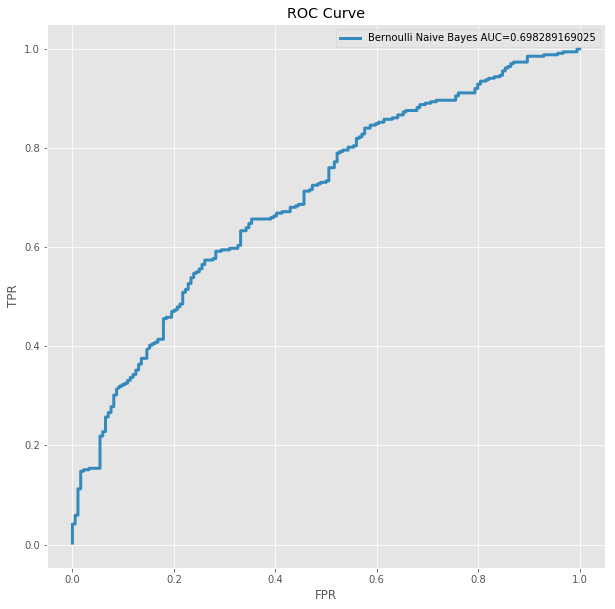

In [32]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

plt.figure(figsize=(10,10))
X_test_trans = count_vector.transform(X_test_join)
y_test = np.array(y_test)

#draw ROC of Bernoulli Naive Bayes
y_score = nb.predict_proba(X_test_trans)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
auc = np.trapz(tpr, fpr)
plt.plot(fpr, tpr, label="Bernoulli Naive Bayes AUC=" + str(auc), lw=3, color='C1')
plt.title('ROC Curve')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

# Summary

This tutorial used product reviews(9 products) from nltk.corpus to do sentiment analysis. <br>
Two different ways to lemmatize the words - using __spaCy__ and __NLTK WordNetLemmatizer__ - and two ways to train the classifier - __NLTK NaiveBayesClassifier__ and __sklearn BernoulliNB__- are included in the tutorial. <br>
They all have pros and cons; no one is significantly better than the other.  The choice can be made base on needs or preferences. <br>
This tutorial is an introduction to sentiment analysis, and hope you get a basic idea of classifying positive and negative reviews.